In [18]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, GlobalAveragePooling1D, Reshape, multiply, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.ticker as ticker
import seaborn as sns

In [33]:
# Load data
data = pd.read_csv('Raw Dataset/train_data.csv')

data['BaseDateTime'] = pd.to_datetime(data['BaseDateTime'])
data.sort_values('BaseDateTime', inplace=True)

print(data.head())

           MMSI BaseDateTime       LAT        LON  SOG    COG  Heading  \
0     338897000   2023-12-30  40.74787  -74.00945  0.1   88.2    511.0   
2389  368127060   2023-12-30  27.81177  -97.41215  0.0  219.4    283.0   
3209  563099000   2023-12-30  32.96436 -117.71983  1.2  124.6    120.0   
1659  367375350   2023-12-30  28.64461  -96.54958  0.0  359.0    178.0   
1843  367533930   2023-12-30  29.76370  -95.09364  0.0   87.3    144.0   

              VesselName         IMO CallSign  VesselType  Status  Length  \
0     SPIRIT OF NEW YORK         NaN  WCW9332        60.0    15.0    47.0   
2389      RAYMOND BUTLER         NaN  WDL3994        57.0     0.0    26.0   
3209        EAGLE VERONA  IMO9597264   9V6223        80.0     3.0   333.0   
1659                 TED         NaN  WDE6064        31.0     0.0    30.0   
1843             MISSION         NaN  WDG4189        31.0    12.0    25.0   

      Width  Draft  Cargo TransceiverClass  
0      10.0    NaN   60.0                A  
23

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 179647 entries, 0 to 179642
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Unnamed: 0.1      179647 non-null  int64         
 1   Unnamed: 0        179647 non-null  int64         
 2   MMSI              179647 non-null  int64         
 3   BaseDateTime      179647 non-null  datetime64[ns]
 4   LAT               179647 non-null  float64       
 5   LON               179647 non-null  float64       
 6   SOG               179647 non-null  float64       
 7   COG               179647 non-null  float64       
 8   Heading           179647 non-null  float64       
 9   VesselName        179647 non-null  object        
 10  IMO               179647 non-null  object        
 11  CallSign          179647 non-null  object        
 12  VesselType        179647 non-null  float64       
 13  Status            179647 non-null  float64       
 14  Length   

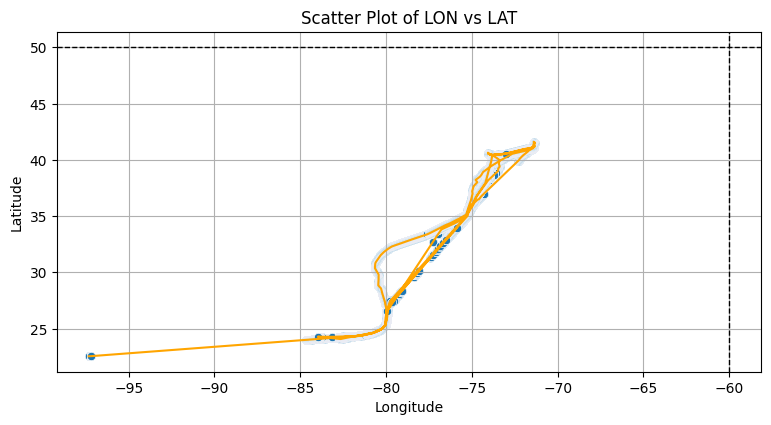

In [21]:
# Create the figure and subplot
plt.figure(figsize=(20, 15))
plt.subplot(3, 2, 3)

# Plot the scatter points
sns.scatterplot(x='LON', y='LAT', data=data)
plt.title('Scatter Plot of LON vs LAT')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add lines connecting the points
plt.plot(data['LON'], data['LAT'], linestyle='-', color='orange')  # Draw straight lines between points

# Add Cartesian grid lines
plt.axhline(y=50, color='black', linestyle='--', linewidth=1)  # Horizontal line at y=0 (x-axis)
plt.axvline(x=-60, color='black', linestyle='--', linewidth=1)  # Vertical line at x=0 (y-axis)
plt.grid(True)  # Enable the grid

# Show the plot
plt.show()


In [22]:
# Feature scaling
scalers = {col: MinMaxScaler() for col in ['LAT', 'LON', 'SOG', 'COG']}
for col, scaler in scalers.items():
    data[[col]] = scaler.fit_transform(data[[col]])


In [23]:
# Create sequences for training
SEQ_LENGTH = 10

def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i+seq_length]
        label = data.iloc[i+seq_length]
        sequences.append((seq[['LAT', 'LON', 'SOG', 'COG']].values, label[['LAT', 'LON']].values))
    return sequences

sequences = create_sequences(data, SEQ_LENGTH)

# Split data into features and labels
X, y = zip(*sequences)
X = np.array(X).astype(np.float32)
y = np.array(y).astype(np.float32)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure Correct Data Types
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)


In [24]:
def squeeze_excite_block(input, ratio=16):
    init = input
    filters = init.shape[-1]
    se_shape = (1, filters)

    se = GlobalAveragePooling1D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = multiply([init, se])
    return x


def build_model(seq_length, embedding_dim):
    input_seq = Input(shape=(seq_length, 4), name='input_seq')

    # CNN layers
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(input_seq)
    x = squeeze_excite_block(x)
    x = GlobalAveragePooling1D()(x)

    # LSTM layers
    lstm_out = LSTM(64)(Lambda(lambda x: tf.expand_dims(x, axis=1))(x))  # Wrap tf.expand_dims

    # Fully connected layers
    output = Dense(2)(lstm_out)

    model = Model(inputs=input_seq, outputs=output)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model


In [25]:
model = build_model(SEQ_LENGTH, 4)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_seq           │ (None, 10, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 8, 64)     │        832 │ input_seq[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ conv1d_1[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 64)     │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1, 4)      │        256 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1, 64)     │        256 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 8, 64)     │          0 │ conv1d_1[0][0],   │
│ (Multiply)          │                   │            │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ multiply_1[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 1, 64)     │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64)        │     33,024 │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 2)         │        130 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 34,498 (134.76 KB)

 Trainable params: 34,498 (134.76 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=1000, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)


In [27]:
# Train the model
history = model.fit(
    X_train, y_train, epochs=100, batch_size=32, 
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr]
)

# Save the model
model.save('prediction_model.h5')

Epoch 1/100
4491/4491 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.0163 - mae: 0.0366 - val_loss: 1.8248e-05 - val_mae: 0.0024 - learning_rate: 0.0010
Epoch 2/100
4491/4491 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 9.6413e-06 - mae: 0.0016 - val_loss: 1.7297e-05 - val_mae: 0.0025 - learning_rate: 0.0010
Epoch 3/100
4491/4491 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 1.4044e-05 - mae: 0.0016 - val_loss: 2.1034e-05 - val_mae: 0.0026 - learning_rate: 0.0010
Epoch 4/100
4491/4491 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 1.1084e-05 - mae: 0.0015 - val_loss: 9.8331e-06 - val_mae: 6.3664e-04 - learning_rate: 0.0010
Epoch 5/100
4491/4491 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 9.0472e-06 - mae: 0.0013 - val_loss: 2.4708e-05 - val_mae: 0.0035 - learning_rate: 0.0010
Epoch 6/100
4491/4491 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 1.1256e-05 - mae: 0.0014 - val_loss: 9.9676e-06 - val_mae: 7.6053e-04 - learning_rate: 0.0010
Epoch 7/100
4491/4491 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 5.1566e-06 - m

In [28]:
# Evaluate the model
y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
y_test[:, 0] = scalers['LAT'].inverse_transform(y_test[:, 0].reshape(-1, 1)).reshape(-1)
y_test[:, 1] = scalers['LON'].inverse_transform(y_test[:, 1].reshape(-1, 1)).reshape(-1)
y_pred[:, 0] = scalers['LAT'].inverse_transform(y_pred[:, 0].reshape(-1, 1)).reshape(-1)
y_pred[:, 1] = scalers['LON'].inverse_transform(y_pred[:, 1].reshape(-1, 1)).reshape(-1)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MAE: {mae}, Test R^2: {r2}")

1123/1123 ━━━━━━━━━━━━━━━━━━━━ 1s 860us/step
Test MAE: 0.004870375618338585, Test R^2: 0.9997119903564453


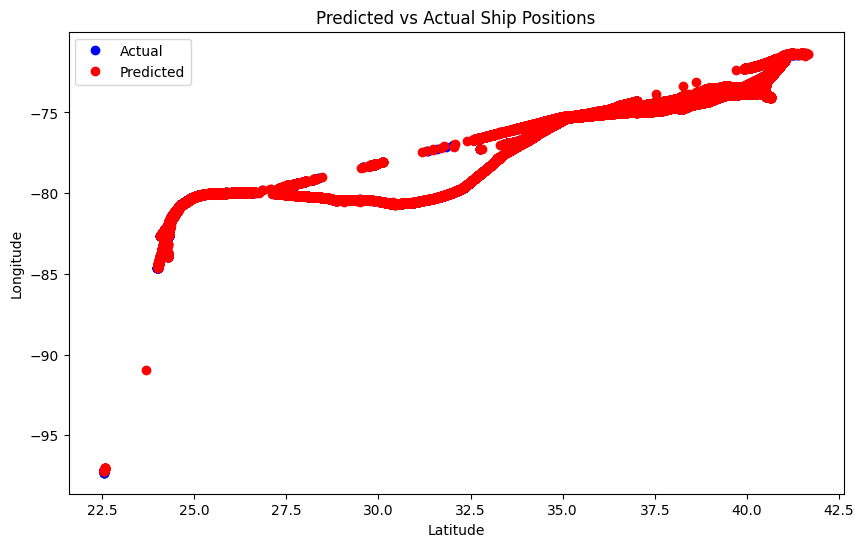

In [29]:
# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.plot(y_test[:, 0], y_test[:, 1], 'bo', label='Actual')
plt.plot(y_pred[:, 0], y_pred[:, 1], 'ro', label='Predicted')
plt.ylabel('Longitude')
plt.xlabel('Latitude')
plt.legend()
plt.title('Predicted vs Actual Ship Positions')
plt.show()

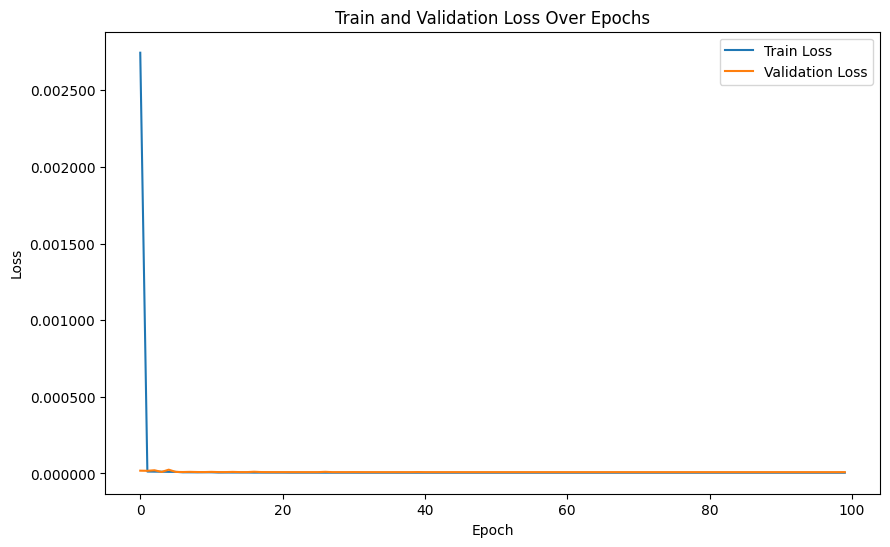

In [30]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss Over Epochs')
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.6f'))  # Show more decimal places
plt.show()


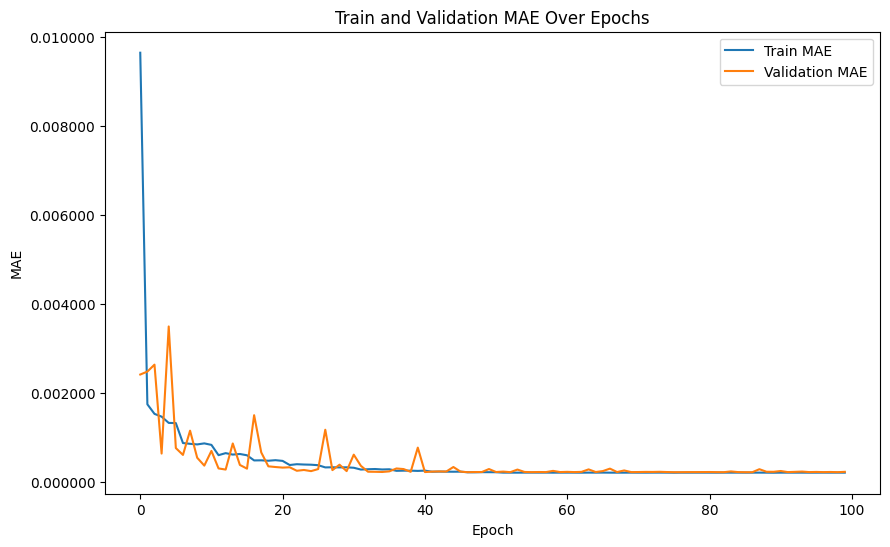

In [31]:
# Plot training & validation MAE values
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.title('Train and Validation MAE Over Epochs')
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.6f'))  # Show more decimal places
plt.show()

In [32]:
def predict_next_position(lat_manual, lon_manual, sog_manual, cog_manual, model, scalers, seq_length=10):
    """
    Memprediksi latitude dan longitude berikutnya berdasarkan input manual dan model yang dilatih.

    Args:
    lat_manual: Latitude yang diinput secara manual.
    lon_manual: Longitude yang diinput secara manual.
    sog_manual: Speed Over Ground (SOG) yang diinput secara manual.
    cog_manual: Course Over Ground (COG) yang diinput secara manual.
    model: Model CNN-LSTM yang sudah dilatih.
    scalers: Dictionary yang berisi scaler untuk setiap fitur (LAT, LON, SOG, COG).
    seq_length: Panjang sequence yang dibutuhkan model, default 10.

    Returns:
    Prediksi latitude dan longitude berikutnya.
    """
    # Buat input array berdasarkan input manual
    input_data = np.array([[lat_manual, lon_manual, sog_manual, cog_manual]])

    # Lakukan scaling sesuai skema sebelumnya
    input_data[:, 0] = scalers['LAT'].transform(input_data[:, 0].reshape(-1, 1)).reshape(-1)
    input_data[:, 1] = scalers['LON'].transform(input_data[:, 1].reshape(-1, 1)).reshape(-1)
    input_data[:, 2] = scalers['SOG'].transform(input_data[:, 2].reshape(-1, 1)).reshape(-1)
    input_data[:, 3] = scalers['COG'].transform(input_data[:, 3].reshape(-1, 1)).reshape(-1)

    # Buat sequence dengan panjang seq_length dengan menduplikasi input manual
    sequence_input = np.tile(input_data, (seq_length, 1))

    # Sesuaikan input dengan panjang sequence yang dibutuhkan model
    sequence_input = np.expand_dims(sequence_input, axis=0).astype(np.float32)

    # Lakukan prediksi
    predicted = model.predict(sequence_input)

    # Lakukan inverse scaling agar prediksi kembali ke skala asli
    predicted[:, 0] = scalers['LAT'].inverse_transform(predicted[:, 0].reshape(-1, 1)).reshape(-1)
    predicted[:, 1] = scalers['LON'].inverse_transform(predicted[:, 1].reshape(-1, 1)).reshape(-1)

    return predicted[0, 0], predicted[0, 1]

# Contoh penggunaan
lat_manual = 24.05323
lon_manual = -84.21892
sog_manual = 22.3
cog_manual = 82.8

predicted_lat, predicted_lon = predict_next_position(lat_manual, lon_manual, sog_manual, cog_manual, model, scalers)

print(f"Prediksi Latitude berikutnya: {predicted_lat}")
print(f"Prediksi Longitude berikutnya: {predicted_lon}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediksi Latitude berikutnya: 24.054752349853516
Prediksi Longitude berikutnya: -84.19287109375


c:\Users\Cheeszy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Cheeszy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Cheeszy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Cheeszy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
